In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

all_sheets = pd.read_excel("air_quality_index_dataset.xlsx", sheet_name=None)
frames = []
for city, dfc in all_sheets.items():
    dfc = dfc.copy()
    dfc["City"] = city
    frames.append(dfc)
df = pd.concat(frames, ignore_index=True)
print("Loaded:", df.shape)


Loaded: (944182, 23)


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

pm25_col = "PM2.5"
others_cols = ["CO","O3","NO2","NO","NOX","SO2"]

df[[pm25_col] + others_cols] = df[[pm25_col] + others_cols].apply(pd.to_numeric, errors='coerce')
imputer = SimpleImputer(strategy="median")
df[[pm25_col] + others_cols] = imputer.fit_transform(df[[pm25_col] + others_cols])


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
others_scaled = scaler.fit_transform(df[others_cols])
pca = PCA(n_components=1)
pca_1 = pca.fit_transform(others_scaled).ravel()

df_pca = pd.DataFrame({
    "PM2_5": df[pm25_col],
    "PCA_others": pca_1
})
print(df_pca.head())


   PM2_5  PCA_others
0  53.54   -0.458559
1  53.54   -0.458559
2  53.54   -0.458559
3  53.54   -0.458559
4  53.54   -0.458559


Fit sample size: 100000
DBSCAN (sample) cluster counts: {np.int64(-1): np.int64(185), np.int64(0): np.int64(99747), np.int64(1): np.int64(10), np.int64(2): np.int64(9), np.int64(3): np.int64(22), np.int64(4): np.int64(6), np.int64(5): np.int64(13), np.int64(6): np.int64(8)}


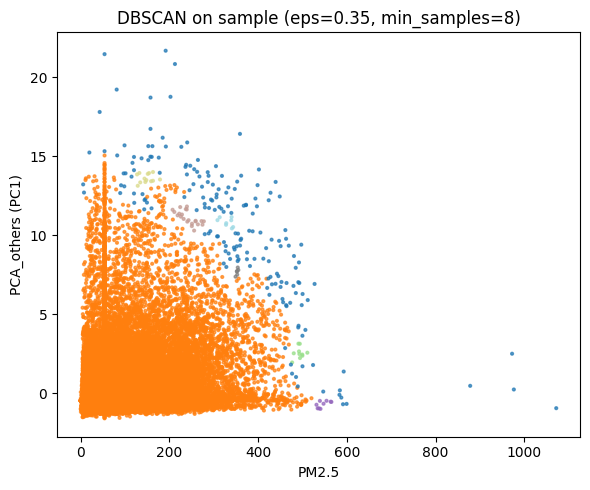

2934

In [ ]:
# ==== DBSCAN clustering first; evaluate later ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import gc

# 0) Build 2D matrix safely (float32, drop NaNs/Infs)
X2 = (
    df_pca[["PM2_5", "PCA_others"]]
    .astype("float32")
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)
valid_idx = X2.index.to_numpy()
X_all = X2.values  # shape (N, 2)

# 1) Sample for fitting DBSCAN (keep it light)
rng = np.random.default_rng(42)
fit_n = min(100_000, len(X_all))   # reduce to 50_000 if RAM is tight
fit_sel = rng.choice(len(X_all), size=fit_n, replace=False)
X_fit = X_all[fit_sel]

# 2) Scale on the fit sample; reuse for everything else
scaler = StandardScaler()
X_fit_scaled = scaler.fit_transform(X_fit).astype("float32")

# 3) DBSCAN on the sample (tune these)
EPS = 0.35
MIN_SAMPLES = 8
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, n_jobs=-1)
fit_labels = db.fit_predict(X_fit_scaled)

# 4) Extract core points from the sample and build a radius-NN on them
core_mask = np.zeros_like(fit_labels, dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = X_fit_scaled[core_mask]
core_labels = fit_labels[core_mask]

# if no clusters formed, bail early
if len(core_points) == 0 or np.unique(core_labels).size <= 1:
    print("DBSCAN found no usable clusters on the sample. Try adjusting EPS/MIN_SAMPLES.")
    df_pca["cluster_label"] = -999
else:
    # NN model to assign clusters to ALL points by nearest core within eps
    # Use 1-NN + distance check against EPS (in scaled space)
    nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(core_points)

    # 5) Assign labels to ALL rows in chunks (keeps RAM stable)
    df_pca["cluster_label"] = -999  # default
    chunk = 100_000  # adjust if needed
    for start in range(0, len(X_all), chunk):
        stop = min(start + chunk, len(X_all))
        X_chunk_scaled = scaler.transform(X_all[start:stop]).astype("float32")
        dists, nbrs = nn.kneighbors(X_chunk_scaled, return_distance=True)
        # within eps? assign that core's label, else -1 (noise)
        assigned = np.where(dists.ravel() <= EPS, core_labels[nbrs.ravel()], -1).astype(np.int32)
        df_pca.loc[valid_idx[start:stop], "cluster_label"] = assigned

    # 6) Quick report (counts only) and a visual on the fit sample
    uniq, cnts = np.unique(fit_labels, return_counts=True)
    print("Fit sample size:", fit_n)
    print("DBSCAN (sample) cluster counts:", dict(zip(uniq, cnts)))  # -1 is noise

    # Plot just the sampled points for a fast visual
    plt.figure(figsize=(6,5))
    plt.scatter(X_fit[:, 0], X_fit[:, 1], c=fit_labels, s=4, alpha=0.7, cmap="tab20")
    plt.xlabel("PM2.5")
    plt.ylabel("PCA_others (PC1)")
    plt.title(f"DBSCAN on sample (eps={EPS}, min_samples={MIN_SAMPLES})")
    plt.tight_layout()
    plt.show()

# 7) Clean up
del X_fit, X_fit_scaled, X_all
gc.collect()


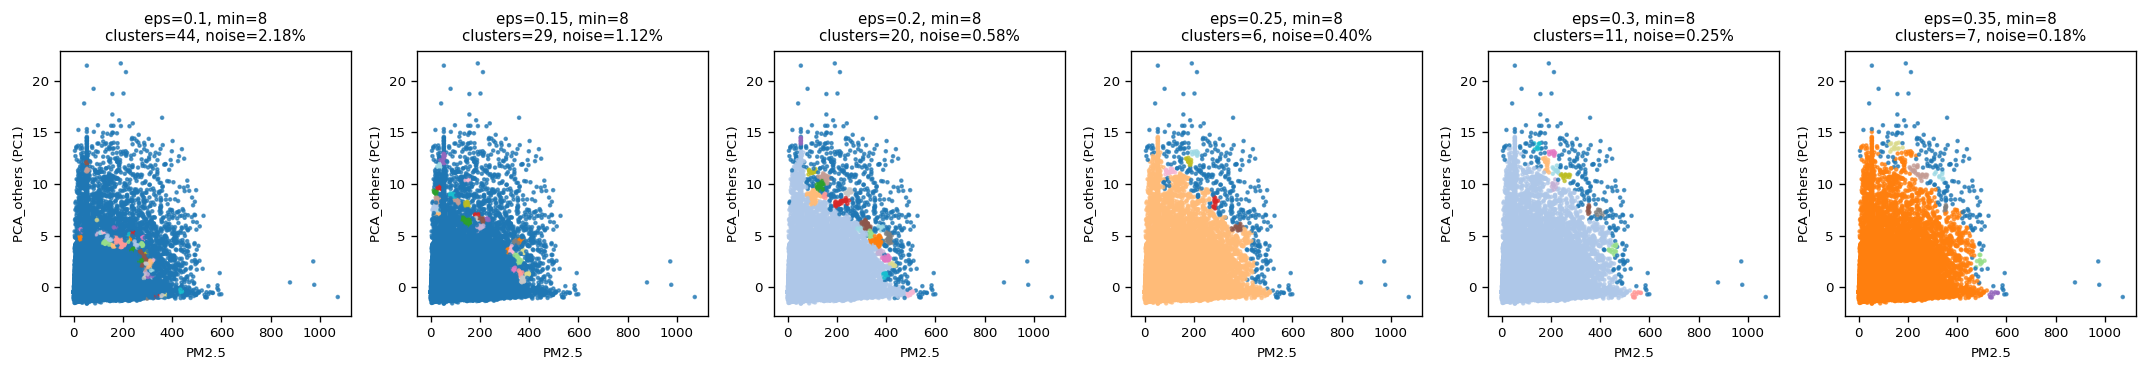

[Heuristic pick] eps=0.1, min_samples=8, clusters=44, noise=2.18%
Chosen params → eps=0.1, min_samples=8
Sample cluster counts: {np.int64(-1): np.int64(2177), np.int64(0): np.int64(97068), np.int64(1): np.int64(18), np.int64(2): np.int64(28), np.int64(3): np.int64(39), np.int64(4): np.int64(16), np.int64(5): np.int64(22), np.int64(6): np.int64(33), np.int64(7): np.int64(29), np.int64(8): np.int64(28), np.int64(9): np.int64(22), np.int64(10): np.int64(47), np.int64(11): np.int64(21), np.int64(12): np.int64(9), np.int64(13): np.int64(15), np.int64(14): np.int64(10), np.int64(15): np.int64(27), np.int64(16): np.int64(85), np.int64(17): np.int64(16), np.int64(18): np.int64(13), np.int64(19): np.int64(10), np.int64(20): np.int64(13), np.int64(21): np.int64(48), np.int64(22): np.int64(15), np.int64(23): np.int64(11), np.int64(24): np.int64(12), np.int64(25): np.int64(14), np.int64(26): np.int64(8), np.int64(27): np.int64(8), np.int64(28): np.int64(12), np.int64(29): np.int64(12), np.int64(30

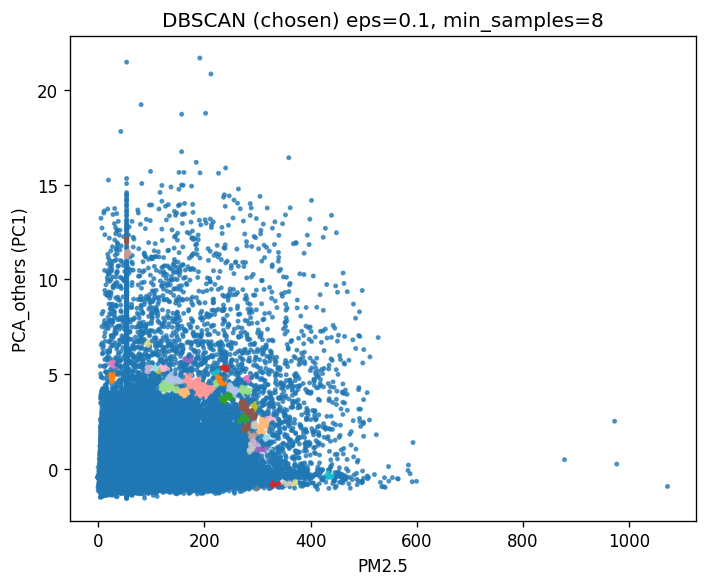

3036

In [ ]:
# ==== DBSCAN parameter sweep (tuning) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import gc

# 0) Build 2D matrix (float32, clean)
X2 = (
    df_pca[["PM2_5", "PCA_others"]]
    .astype("float32")
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)
valid_idx = X2.index.to_numpy()
X_all = X2.values

# 1) Sample for tuning (keeps RAM safe)
rng = np.random.default_rng(42)
fit_n = min(100_000, len(X_all))  # try 50_000 if RAM is tight
fit_sel = rng.choice(len(X_all), size=fit_n, replace=False)
X_fit = X_all[fit_sel]

# 2) Scale on the fit sample
scaler = StandardScaler()
X_fit_scaled = scaler.fit_transform(X_fit).astype("float32")

# 3) Try a grid of eps (and optionally min_samples)
EPS_LIST = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35]
MIN_SAMPLES_LIST = [8]  # you can try [8, 12] if you want a bigger grid

results = []
nrows = len(MIN_SAMPLES_LIST)
ncols = len(EPS_LIST)

plt.figure(figsize=(3.0*ncols, 3.2*nrows), dpi=120)
plot_i = 1

for m in MIN_SAMPLES_LIST:
    for e in EPS_LIST:
        db = DBSCAN(eps=e, min_samples=m, n_jobs=-1)
        labels = db.fit_predict(X_fit_scaled)

        # basic stats
        unique, counts = np.unique(labels, return_counts=True)
        counts_d = dict(zip(unique, counts))
        n_clusters = len([u for u in unique if u != -1])
        noise_frac = counts_d.get(-1, 0) / len(labels)

        results.append((e, m, n_clusters, noise_frac, counts_d, labels))

        # quick scatter
        ax = plt.subplot(nrows, ncols, plot_i)
        s = ax.scatter(X_fit[:, 0], X_fit[:, 1], c=labels, s=3, alpha=0.7, cmap="tab20")
        ax.set_title(f"eps={e}, min={m}\nclusters={n_clusters}, noise={noise_frac:.2%}", fontsize=9)
        ax.set_xlabel("PM2.5", fontsize=8)
        ax.set_ylabel("PCA_others (PC1)", fontsize=8)
        ax.tick_params(labelsize=8)
        plot_i += 1

plt.tight_layout()
plt.show()

# 4) Heuristic pick (you can override)
# Prefer: 2-12 clusters, 2%-25% noise. If none match, pick highest cluster count.
candidates = []
for (e, m, k, nf, cnts, labels) in results:
    score = 0
    # cluster count closeness to mid (target ~5)
    if k > 1:
        score += min(k, 12)
    # noise in a moderate band
    if 0.02 <= nf <= 0.25:
        score += 5
    candidates.append((score, e, m, k, nf))

candidates.sort(reverse=True)
if candidates:
    best_score, BEST_EPS, BEST_MIN_SAMPLES, best_k, best_nf = candidates[0]
    print(f"[Heuristic pick] eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}, "
          f"clusters={best_k}, noise={best_nf:.2%}")
else:
    BEST_EPS, BEST_MIN_SAMPLES = 0.20, 8
    print("[Heuristic pick] fallback:", BEST_EPS, BEST_MIN_SAMPLES)

# === If you want to override manually, set them here:
# BEST_EPS = 0.20
# BEST_MIN_SAMPLES = 8

# 5) Fit once on sample with chosen params, then label ALL rows using core points
db_best = DBSCAN(eps=BEST_EPS, min_samples=BEST_MIN_SAMPLES, n_jobs=-1)
fit_labels = db_best.fit_predict(X_fit_scaled)

core_mask = np.zeros_like(fit_labels, dtype=bool)
core_mask[db_best.core_sample_indices_] = True
core_points = X_fit_scaled[core_mask]
core_labels = fit_labels[core_mask]

df_pca["cluster_label"] = -999  # default (unassigned)
if len(core_points) == 0 or np.unique(core_labels).size <= 1:
    print("Best params produced no usable clusters. Try a different eps/min_samples.")
else:
    # nearest core-point assignment within eps, in chunks
    nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(core_points)
    chunk = 100_000
    for start in range(0, len(X_all), chunk):
        stop = min(start + chunk, len(X_all))
        X_chunk_scaled = scaler.transform(X_all[start:stop]).astype("float32")
        dists, nbrs = nn.kneighbors(X_chunk_scaled, return_distance=True)
        assigned = np.where(dists.ravel() <= BEST_EPS,
                            core_labels[nbrs.ravel()],
                            -1).astype(np.int32)
        df_pca.loc[valid_idx[start:stop], "cluster_label"] = assigned

    # quick summary on the fit sample
    uniq, cnts = np.unique(fit_labels, return_counts=True)
    print("Chosen params →", f"eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}")
    print("Sample cluster counts:", dict(zip(uniq, cnts)))  # -1 is noise

    # quick plot for chosen params (sample only, for speed)
    plt.figure(figsize=(6,5), dpi=120)
    plt.scatter(X_fit[:, 0], X_fit[:, 1], c=fit_labels, s=4, alpha=0.7, cmap="tab20")
    plt.xlabel("PM2.5")
    plt.ylabel("PCA_others (PC1)")
    plt.title(f"DBSCAN (chosen) eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}")
    plt.tight_layout()
    plt.show()

# 6) Cleanup
del X_fit, X_fit_scaled, X_all
gc.collect()


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# 1) Take only the two features we care about
X2 = (
    df_pca[["PM2_5", "PCA_others"]]
    .astype("float32")
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)
valid_idx = X2.index.to_numpy()
X_all = X2.values

# 2) Pick a manageable sample to actually run DBSCAN
rng = np.random.default_rng(42)
fit_n = min(100_000, len(X_all))   # you can reduce to 50_000 if RAM feels tight
fit_sel = rng.choice(len(X_all), size=fit_n, replace=False)
X_fit = X_all[fit_sel]

# 3) Scale based on sample
scaler = StandardScaler()
X_fit_scaled = scaler.fit_transform(X_fit).astype("float32")

# 4) Run DBSCAN on the sample only
BEST_EPS = 0.10
BEST_MIN_SAMPLES = 8
db = DBSCAN(eps=BEST_EPS, min_samples=BEST_MIN_SAMPLES, n_jobs=-1)
fit_labels = db.fit_predict(X_fit_scaled)

# 5) Get core points
core_mask = np.zeros_like(fit_labels, dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = X_fit_scaled[core_mask]
core_labels = fit_labels[core_mask]

# 6) Assign cluster labels to ALL rows using nearest core point
nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(core_points)

df_pca["cluster_label"] = -999
chunk = 50_000   # adjust chunk size if RAM is tight
total = len(X_all)

for start in range(0, total, chunk):
    stop = min(start + chunk, total)
    X_chunk_scaled = scaler.transform(X_all[start:stop]).astype("float32")
    dists, nbrs = nn.kneighbors(X_chunk_scaled, return_distance=True)
    assigned = np.where(
        dists.ravel() <= BEST_EPS, core_labels[nbrs.ravel()], -1
    ).astype(np.int32)
    df_pca.loc[valid_idx[start:stop], "cluster_label"] = assigned
    print(f"Labeled {stop}/{total} rows...")

# 7) Print final counts
print("Cluster counts (including noise):")
print(df_pca["cluster_label"].value_counts().head(20))


Labeled 50000/944182 rows...
Labeled 100000/944182 rows...
Labeled 150000/944182 rows...
Labeled 200000/944182 rows...
Labeled 250000/944182 rows...
Labeled 300000/944182 rows...
Labeled 350000/944182 rows...
Labeled 400000/944182 rows...
Labeled 450000/944182 rows...
Labeled 500000/944182 rows...
Labeled 550000/944182 rows...
Labeled 600000/944182 rows...
Labeled 650000/944182 rows...
Labeled 700000/944182 rows...
Labeled 750000/944182 rows...
Labeled 800000/944182 rows...
Labeled 850000/944182 rows...
Labeled 900000/944182 rows...
Labeled 944182/944182 rows...
Cluster counts (including noise):
cluster_label
 0     915654
-1      22629
 16       707
 10       498
 21       360
 3        302
 8        280
 7        272
 6        231
 9        191
 15       186
 2        174
 34       153
 22       142
 13       135
 20       133
 11       130
 17       130
 5        128
 25       125
Name: count, dtype: int64


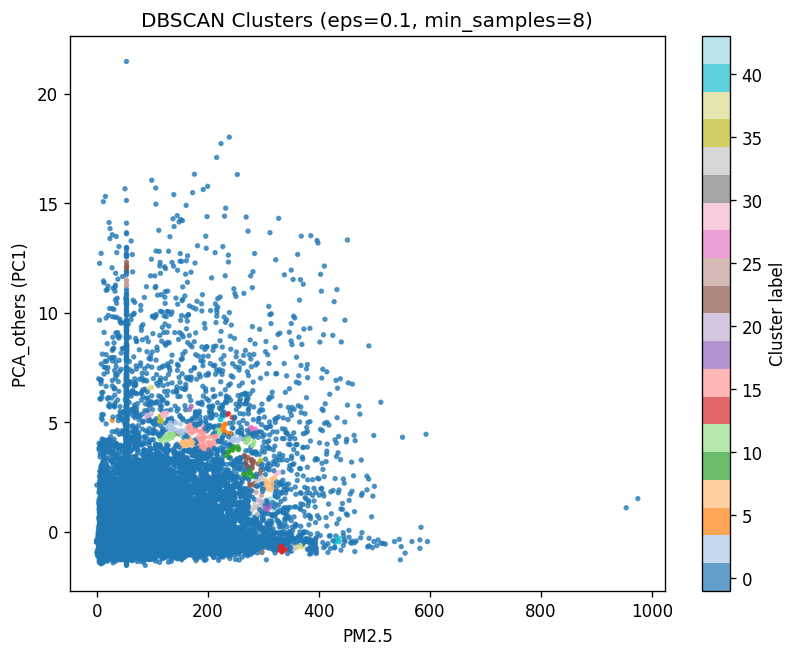

In [ ]:
import matplotlib.pyplot as plt

# Take a random subset for plotting (so it doesn’t overcrowd)
plot_sample = df_pca.sample(n=50_000, random_state=42)

plt.figure(figsize=(8,6), dpi=120)
scatter = plt.scatter(
    plot_sample["PM2_5"],
    plot_sample["PCA_others"],
    c=plot_sample["cluster_label"],
    s=5, alpha=0.7, cmap="tab20"
)
plt.xlabel("PM2.5")
plt.ylabel("PCA_others (PC1)")
plt.title("DBSCAN Clusters (eps=0.1, min_samples=8)")
plt.colorbar(scatter, label="Cluster label")
plt.show()

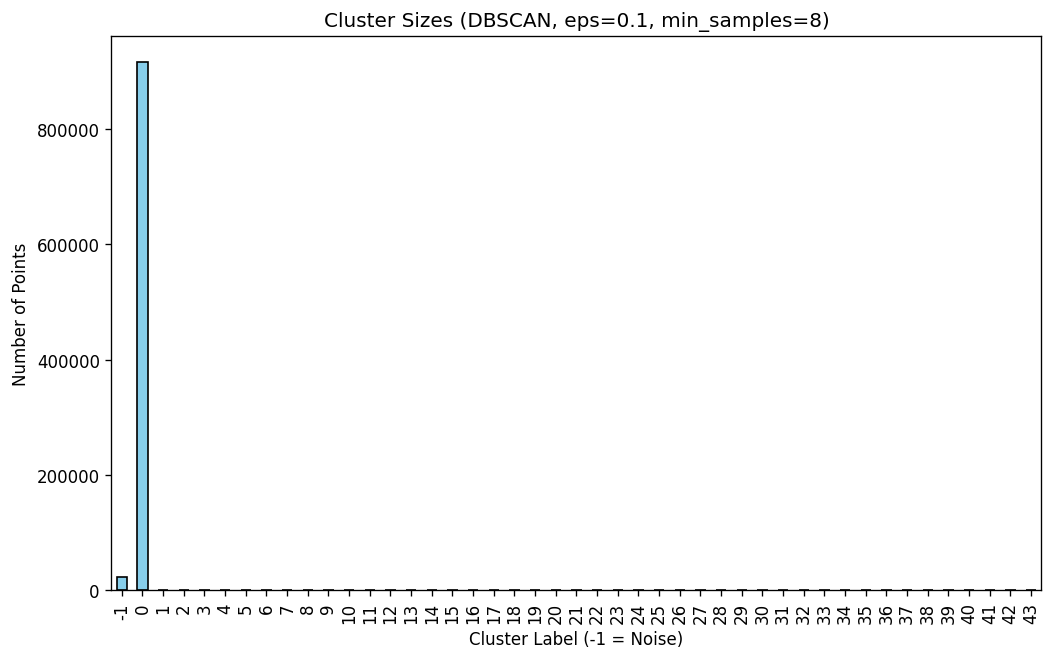

In [ ]:
import matplotlib.pyplot as plt

# Count rows per cluster
cluster_counts = df_pca["cluster_label"].value_counts().sort_index()

plt.figure(figsize=(10,6), dpi=120)
cluster_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Cluster Sizes (DBSCAN, eps=0.1, min_samples=8)")
plt.xlabel("Cluster Label (-1 = Noise)")
plt.ylabel("Number of Points")
plt.xticks(rotation=90)
plt.show()

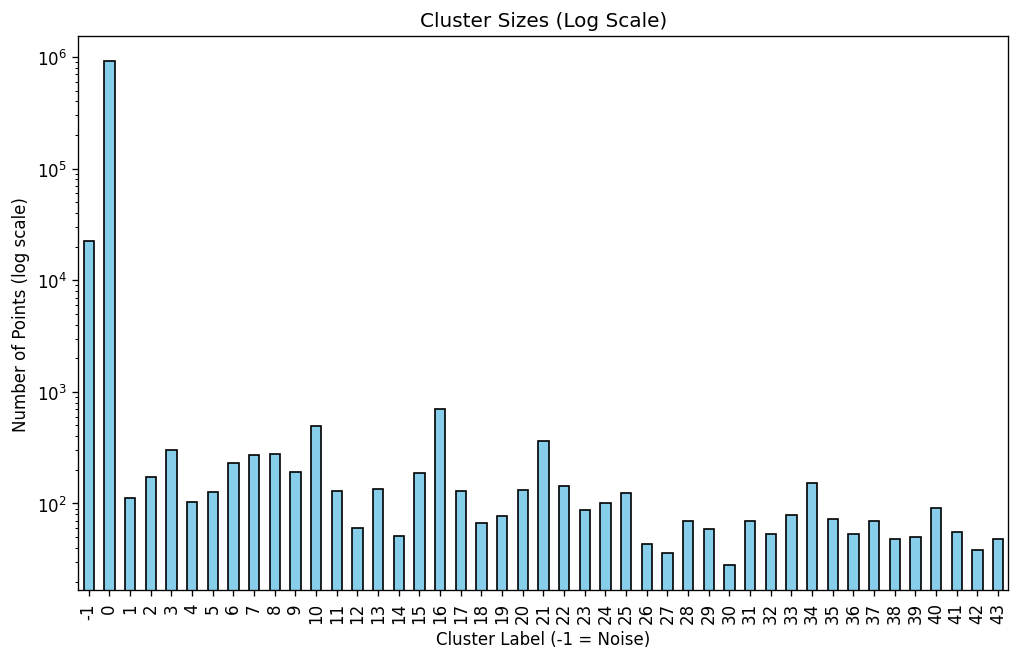

In [ ]:
plt.figure(figsize=(10,6), dpi=120)
cluster_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.yscale("log")  # 👈 makes small clusters visible
plt.title("Cluster Sizes (Log Scale)")
plt.xlabel("Cluster Label (-1 = Noise)")
plt.ylabel("Number of Points (log scale)")
plt.xticks(rotation=90)
plt.show()

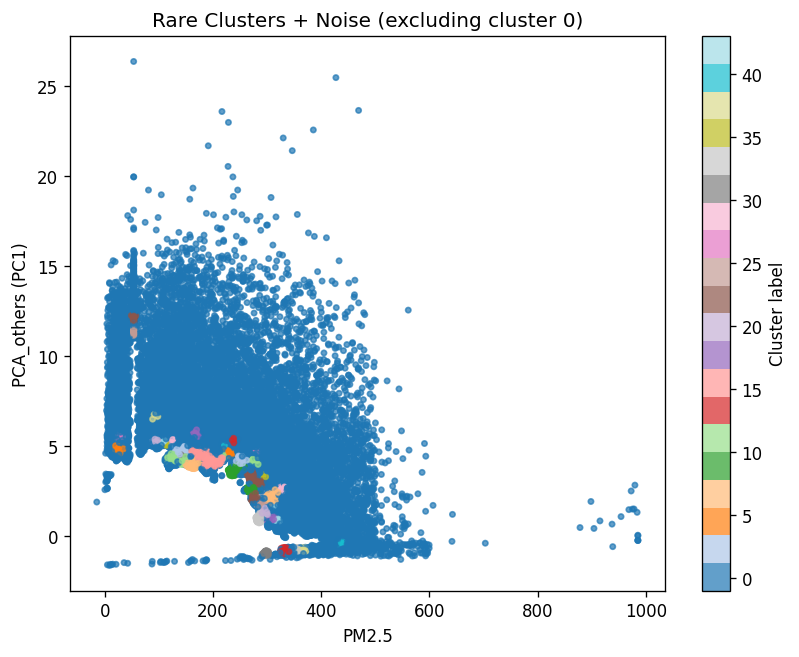

In [ ]:
rare_sample = df_pca[df_pca["cluster_label"] != 0].sample(n=20000, random_state=42)
plt.figure(figsize=(8,6), dpi=120)
plt.scatter(
    rare_sample["PM2_5"],
    rare_sample["PCA_others"],
    c=rare_sample["cluster_label"],
    s=10, alpha=0.7, cmap="tab20"
)
plt.xlabel("PM2.5")
plt.ylabel("PCA_others (PC1)")
plt.title("Rare Clusters + Noise (excluding cluster 0)")
plt.colorbar(label="Cluster label")
plt.show()


In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Use only non-noise points for evaluation
mask = df_pca["cluster_label"] != -1
X_eval = df_pca.loc[mask, ["PM2_5", "PCA_others"]].values.astype("float32")
y_eval = df_pca.loc[mask, "cluster_label"].values

if len(np.unique(y_eval)) > 1:  # need at least 2 clusters
    dbi = davies_bouldin_score(X_eval, y_eval)
    ch = calinski_harabasz_score(X_eval, y_eval)
    print(f"Davies–Bouldin Index: {dbi:.4f}")
    print(f"Calinski–Harabasz Index: {ch:.2f}")
else:
    print("Not enough clusters (after removing noise) to compute metrics.")

Davies–Bouldin Index: 3.1761
Calinski–Harabasz Index: 1671.15


In [ ]:
print(df_pca.columns.tolist())

['PM2_5', 'PCA_others', 'cluster_label']


In [ ]:
df_pca = df_pca.join(df['City'])   # bring back City

In [ ]:
print(df_pca.columns.tolist())

['PM2_5', 'PCA_others', 'cluster_label', 'City']


cluster_label        -1      0    1    2    3    4    5    6    7    8   ...  \
City                                                                     ...   
Agrabad Chittagong  1885  77809   10    5   14   34    6   12   20    8  ...   
BARC                6063  73228   34    2   96   18    5    3   44    4  ...   
Barishal             967  78745    9    7   34    3    2    7   24    8  ...   
Cumilla               42  17206    0    0    0    0    0    0    0    0  ...   
Darussalam          3728  75368   25   52   60    1   38   22   50   53  ...   

cluster_label        34   35   36   37   38   39   40   41   42   43  
City                                                                  
Agrabad Chittagong   14    5    3    1    4    1    2    3    3    3  
BARC                  1    2   28    8   25    6   15   32    1    1  
Barishal              7    5    5    1    1    1    2    2    5    1  
Cumilla               0    0    0    1    0    0    1    0    0    0  
Darussalam   

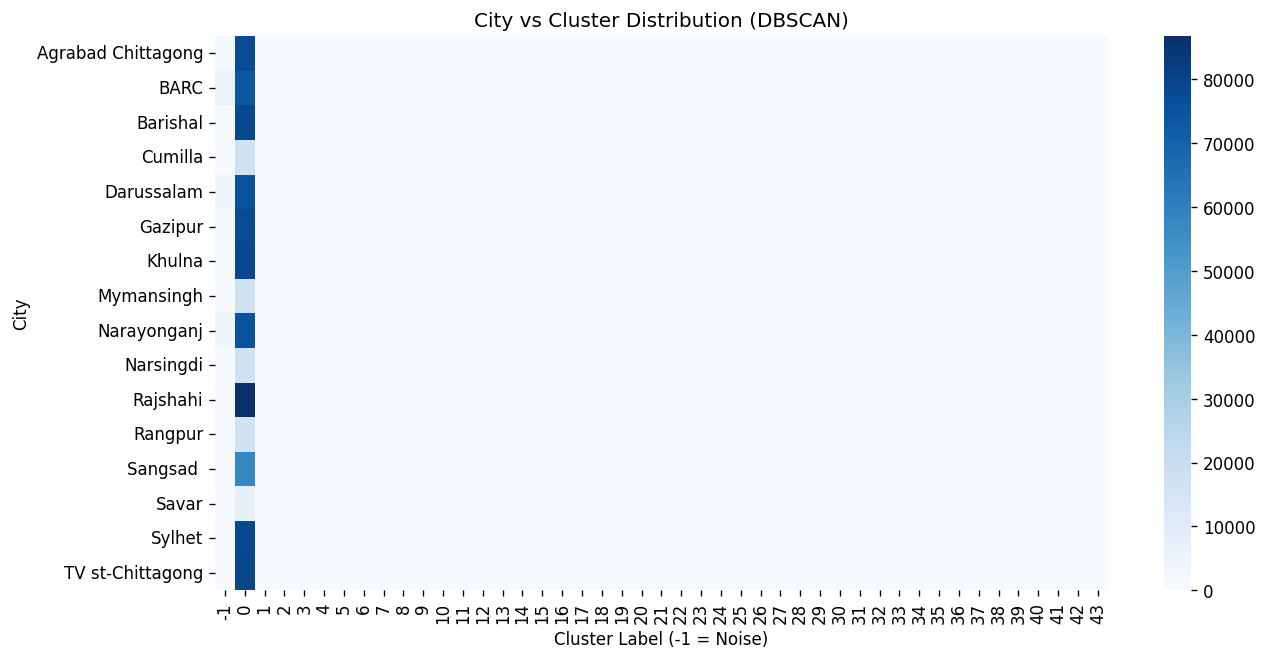

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count how many rows per city per cluster
city_cluster_counts = df_pca.groupby(["City", "cluster_label"]).size().unstack(fill_value=0)

# Show first few rows
print(city_cluster_counts.head())

# Heatmap visualization
plt.figure(figsize=(12,6), dpi=120)
sns.heatmap(city_cluster_counts, cmap="Blues", cbar=True)
plt.title("City vs Cluster Distribution (DBSCAN)")
plt.xlabel("Cluster Label (-1 = Noise)")
plt.ylabel("City")
plt.show()

cluster_label        -1      0    1    2    3    4    5    6    7    8   ...  \
City                                                                     ...   
Agrabad Chittagong  1885  77809   10    5   14   34    6   12   20    8  ...   
BARC                6063  73228   34    2   96   18    5    3   44    4  ...   
Barishal             967  78745    9    7   34    3    2    7   24    8  ...   
Cumilla               42  17206    0    0    0    0    0    0    0    0  ...   
Darussalam          3728  75368   25   52   60    1   38   22   50   53  ...   

cluster_label        34   35   36   37   38   39   40   41   42   43  
City                                                                  
Agrabad Chittagong   14    5    3    1    4    1    2    3    3    3  
BARC                  1    2   28    8   25    6   15   32    1    1  
Barishal              7    5    5    1    1    1    2    2    5    1  
Cumilla               0    0    0    1    0    0    1    0    0    0  
Darussalam   

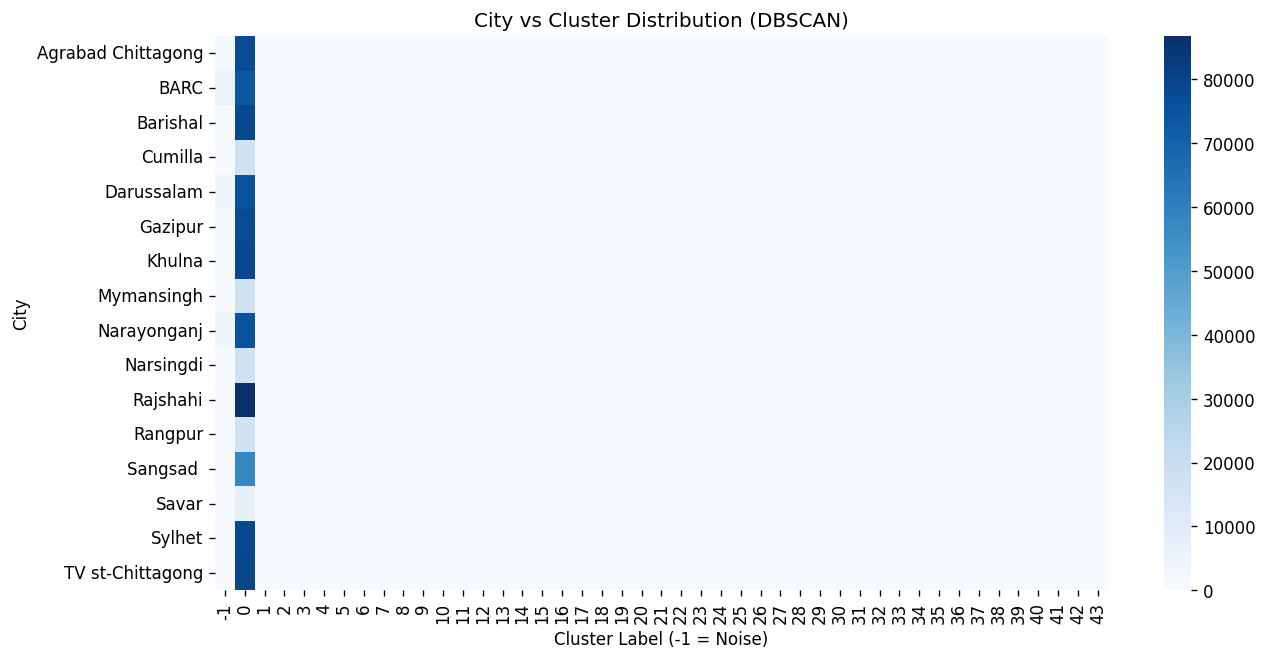

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure cluster labels exist too
assert 'cluster_label' in df_pca.columns, "cluster_label is missing — create it before this step."

city_cluster_counts = pd.crosstab(df_pca['City'], df_pca['cluster_label'])

print(city_cluster_counts.head())

plt.figure(figsize=(12, 6), dpi=120)
sns.heatmap(city_cluster_counts, cmap="Blues", cbar=True)
plt.title("City vs Cluster Distribution (DBSCAN)")
plt.xlabel("Cluster Label (-1 = Noise)")
plt.ylabel("City")
plt.show()

Text(0.5, 1.0, 'City vs Cluster (log-scaled counts)')

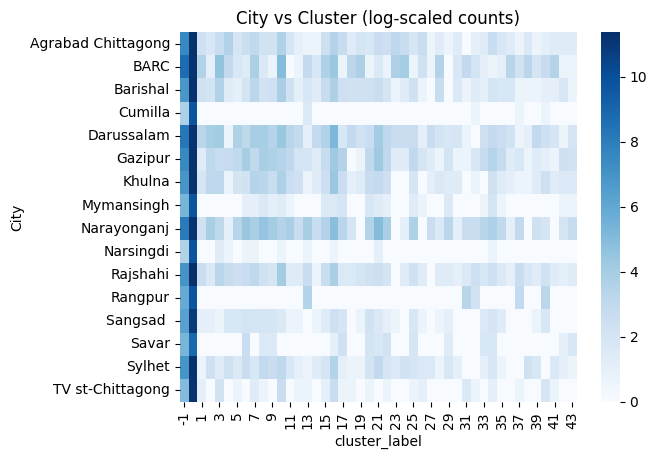

In [ ]:
# 1) Log-scale counts so small clusters are visible
import numpy as np
viz = np.log1p(city_cluster_counts)  # log(1+x)
sns.heatmap(viz, cmap="Blues", cbar=True)
plt.title("City vs Cluster (log-scaled counts)")

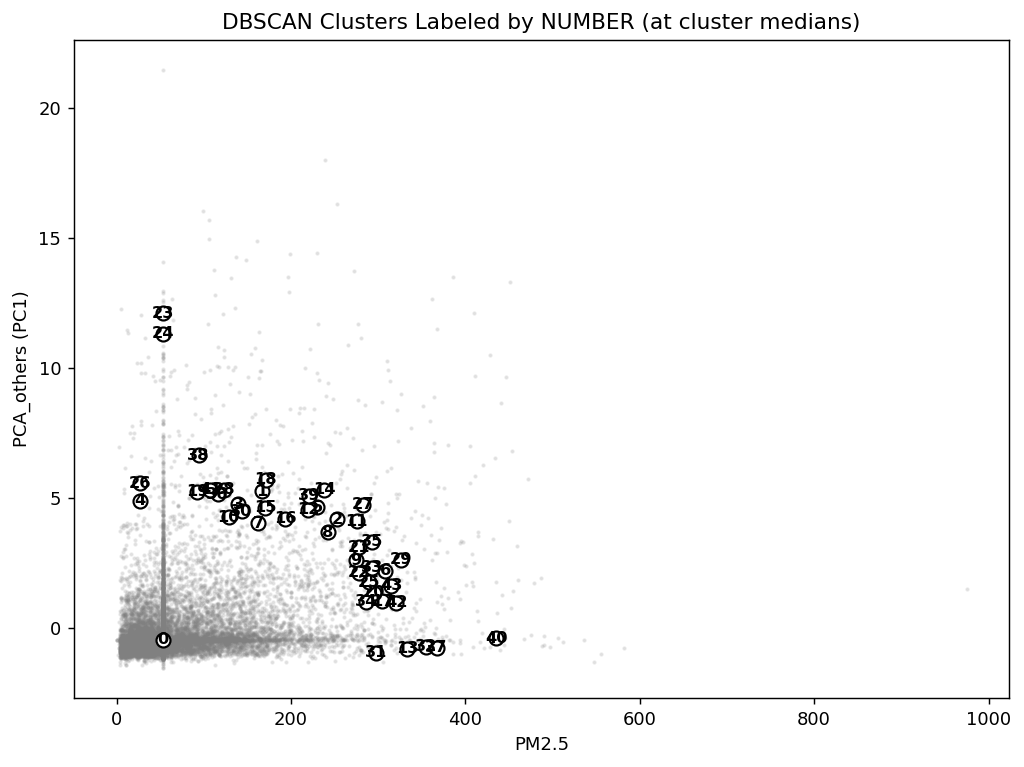

In [ ]:
import matplotlib.pyplot as plt

if not df_assigned.empty:
    # Sample (to keep plot fast & readable)
    # If you prefer all points, set sample_frac=1.0 (may be heavy)
    sample_frac = 0.02
    df_sample = df_pca.sample(frac=sample_frac, random_state=42) if len(df_pca) > 50000 else df_pca.copy()

    plt.figure(figsize=(8,6), dpi=130)
    # context cloud (gray)
    plt.scatter(df_sample["PM2_5"], df_sample["PCA_others"], s=2, alpha=0.15, c="gray")

    # label each cluster by number at its median position
    for _, row in cluster_summary.iterrows():
        cl = int(row["cluster_label"])
        x  = row["pm25_median"]
        y  = row["pca_median"]
        # A small circle for the center
        plt.scatter([x],[y], s=60, edgecolor="black", facecolor="white", linewidth=1.2, zorder=3)
        # The cluster number
        plt.text(x, y, str(cl), fontsize=9, ha="center", va="center", weight="bold", zorder=4)

    plt.xlabel("PM2.5")
    plt.ylabel("PCA_others (PC1)")
    plt.title("DBSCAN Clusters Labeled by NUMBER (at cluster medians)")
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Keep only assigned points (exclude noise = -1)
df_assigned = df_pca.loc[df_pca["cluster_label"] != -1, ["PM2_5","PCA_others","cluster_label"]].copy()

if df_assigned.empty:
    print("No assigned clusters to summarize. Try different eps/min_samples.")
else:
    # TERTILES for Low/Moderate/High buckets (keep as-is to avoid extra params)
    pm_q1, pm_q2  = df_pca["PM2_5"].quantile([0.33, 0.66]).values
    pca_q1, pca_q2 = df_pca["PCA_others"].quantile([0.33, 0.66]).values

    def bucket(v, q1, q2):
        if v <= q1: return "Low"
        if v <= q2: return "Moderate"
        return "High"

    # Per-cluster medians & sizes
    cluster_summary = (
        df_assigned
        .groupby("cluster_label")
        .agg(pm25_median=("PM2_5","median"),
             pca_median=("PCA_others","median"),
             n=("PM2_5","size"))
        .reset_index()
        .sort_values("cluster_label")
    )

    # Bucket each cluster by its medians
    cluster_summary["PM2_5_level"] = cluster_summary["pm25_median"].apply(lambda v: bucket(v, pm_q1, pm_q2))
    cluster_summary["PCA_level"]   = cluster_summary["pca_median"].apply(lambda v: bucket(v, pca_q1, pca_q2))
    cluster_summary["Generalized"] = cluster_summary["PCA_level"] + " PCA • " + cluster_summary["PM2_5_level"] + " PM2.5"

    # ---- Deterministic GroupID mapping (3×3 grid) ----
    # Rows = PCA level (Low, Moderate, High)
    # Cols = PM2.5 level (Low, Moderate, High)
    levels = ["Low","Moderate","High"]
    def group_id(pca_level, pm_level):
        r = levels.index(pca_level)  # 0,1,2
        c = levels.index(pm_level)   # 0,1,2
        return r*len(levels) + c + 1 # 1..9

    cluster_summary["GroupID"] = cluster_summary.apply(lambda r: group_id(r["PCA_level"], r["PM2_5_level"]), axis=1)

    # Legend (shows all 9 groups consistently—whether present or not)
    legend_rows = []
    for i, pca_lv in enumerate(levels):
        for j, pm_lv in enumerate(levels):
            gid = i*len(levels) + j + 1
            legend_rows.append({"GroupID": gid, "Meaning": f"{pca_lv} PCA • {pm_lv} PM2.5"})
    legend_df = pd.DataFrame(legend_rows).sort_values("GroupID").reset_index(drop=True)

    print("Per-cluster summary (medians, buckets, and GroupID):")
    print(cluster_summary[["cluster_label","n","pm25_median","pca_median","PM2_5_level","PCA_level","GroupID","Generalized"]].to_string(index=False))

    print("\nGroupID legend (deterministic):")
    print(legend_df.to_string(index=False))

    # Handy mappings for later
    cluster_to_group = dict(zip(cluster_summary["cluster_label"], cluster_summary["GroupID"]))
    cluster_to_text  = dict(zip(cluster_summary["cluster_label"], cluster_summary["Generalized"]))

    print("\nCluster → Group mapping:")
    for cl in sorted(cluster_to_group):
        print(f"  Cluster {cl:>3} → Group {cluster_to_group[cl]}  ({cluster_to_text[cl]})")


Per-cluster summary (medians, buckets, and GroupID):
 cluster_label      n  pm25_median  pca_median PM2_5_level PCA_level  GroupID               Generalized
             0 915654       53.540   -0.458559         Low  Moderate        4  Moderate PCA • Low PM2.5
             1    113      166.350    5.250853        High      High        9     High PCA • High PM2.5
             2    174      252.835    4.184743        High      High        9     High PCA • High PM2.5
             3    302      139.675    4.752032        High      High        9     High PCA • High PM2.5
             4    104       26.750    4.894332         Low      High        7      High PCA • Low PM2.5
             5    128      230.330    4.651949        High      High        9     High PCA • High PM2.5
             6    231      308.280    2.192485        High      High        9     High PCA • High PM2.5
             7    272      162.505    4.019016        High      High        9     High PCA • High PM2.5
           

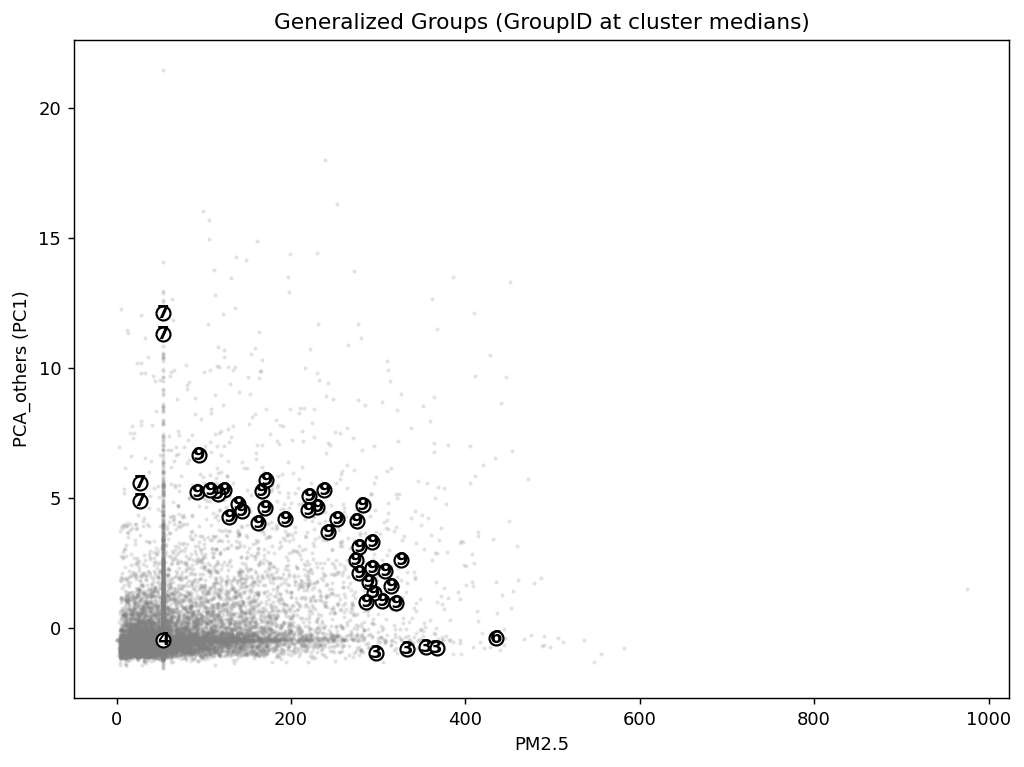


What each GroupID means:
 GroupID                       Meaning
       1           Low PCA • Low PM2.5
       2      Low PCA • Moderate PM2.5
       3          Low PCA • High PM2.5
       4      Moderate PCA • Low PM2.5
       5 Moderate PCA • Moderate PM2.5
       6     Moderate PCA • High PM2.5
       7          High PCA • Low PM2.5
       8     High PCA • Moderate PM2.5
       9         High PCA • High PM2.5


In [ ]:
import matplotlib.pyplot as plt

if not df_assigned.empty:
    # Light context cloud so the numbers stand out
    if len(df_pca) > 50000:
        df_sample = df_pca.sample(frac=0.02, random_state=42)
    else:
        df_sample = df_pca.copy()

    plt.figure(figsize=(8,6), dpi=130)
    plt.scatter(df_sample["PM2_5"], df_sample["PCA_others"], s=2, alpha=0.15, c="gray")

    # Place the GroupID number at each cluster's median
    for _, row in cluster_summary.iterrows():
        x, y = row["pm25_median"], row["pca_median"]
        gid  = int(row["GroupID"])
        plt.scatter([x],[y], s=60, edgecolor="black", facecolor="white", linewidth=1.2, zorder=3)
        plt.text(x, y, str(gid), fontsize=10, ha="center", va="center", weight="bold", zorder=4)

    plt.xlabel("PM2.5")
    plt.ylabel("PCA_others (PC1)")
    plt.title("Generalized Groups (GroupID at cluster medians)")
    plt.tight_layout()
    plt.show()

    # Also print the legend again under the plot for the slide notes
    print("\nWhat each GroupID means:")
    print(legend_df.to_string(index=False))